# Load Tables into a Knowledge Graph

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item">
    <li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li>
    <li><span><a href="#Data" data-toc-modified-id="Data-2">Data</a></span></li>
    <li><span><a href="#Setup" data-toc-modified-id="Setup-3">Setup</a></span></li>
        <ul class="toc-item">
            <li><span><a href="#Import-necessary-libraries" data-toc-modified-id="Import-necessary-libraries-3.1">Import necessary libraries</a></span></li>
        </ul>
    <li><span><a href="#Create-classes" data-toc-modified-id="Create-classes-4">Create classes</a></span></li>
        <ul class="toc-item">
            <li><span><a href="#Import-table-class" data-toc-modified-id="Import-table-class-4.1">ImportTable class</a></span></li>
            <li><span><a href="#Provenance-configuration-class" data-toc-modified-id="Provenance-configuration-class-4.2">ProvenanceConfiguration class</a></span></li>
            <li><span><a href="#Load-table-property-class" data-toc-modified-id="Load-table-property-class-4.3">LoadTableProperty class</a></span></li>
            <li><span><a href="#Relationship-endpoint-class" data-toc-modified-id="Relationship-endpoint-class-4.4">RelationshipEndpoint class</a></span></li>
            <li><span><a href="#Load-table-entity-type-class" data-toc-modified-id="Load-table-entity-type-class-4.5">LoadTableEntityType class</a></span></li>
            <li><span><a href="#Load-table-relationship-type-class" data-toc-modified-id="Load-table-relationship-type-class-4.6">LoadTableRelationshipType class</a></span></li>
        </ul>
    <li><span><a href="#Loading-functions" data-toc-modified-id="Loading-functions-5">Loading functions</a></span></li>
        <ul class="toc-item">
            <li><span><a href="#Process-type-to-data-model" data-toc-modified-id="Process-type-to-data-model-5.1">process_type_to_data_model function</a></span></li>
            <li><span><a href="#Add-provenance-records" data-toc-modified-id="Add-provenance-records-5.2">add_provenance function</a></span></li>
            <li><span><a href="#Process-type-to-instances" data-toc-modified-id="Process-type-to-instances-5.3">process_type_to_instances function</a></span></li>
            <li><span><a href="#Load-tables" data-toc-modified-id="Load-tables-5.4">load_tables function</a></span></li>
        </ul>
    <li><span><a href="#Setup-input-data" data-toc-modified-id="Setup-input-data-6">Setup input data</a></span></li>
    <li><span><a href="#Load-tables-using-functions" data-toc-modified-id="Load-tables-using-functions-7">Load tables using functions</a></span></li>
</ul></div>

## Introduction

Loading tables of data into a knowledge graph is a vital step to set up the graph for analysis. This process includes deciding on how you want to model the data, determining the types and properties that will be created, and loading data from all of your tables in to complete the graph.

During the data loading process, it's important to be able to merge data in order to ensure there are not duplicates of the same entities or relationships created. It is also important to be able to add information about the provenance of your data at the time of loading so you can track that information effectively. Both of these have been included in this example and will provide a starting point for implementing merge and provenance for your own datasets.

## Data

The data we will be using is synthetic data representing a People, Objects, Locations, and Events (POLE) dataset with the location information located in the UK. The data has been used as a graph example and you can find more information about it at https://github.com/neo4j-graph-examples/pole The csv files used in this ntoebook are located at data/pole-data-importer.zip

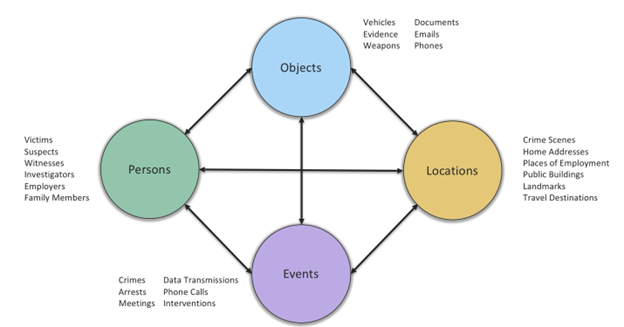

## Setup

### Import necessary libraries
We will be importing the os and json libraries for dealing with our input tables and manipulating data. The pandas library will be used for cleaning and preparing the csvs that we will be using before passing them into the loading function. Finally, GIS is used to connect to our portal and create the service we will be using and KnowledgeGraph along with the following classes will allow us to create the correct structures easily for creating the data model and data for our knowledge graph.

In [1]:
# import libraries
import json, os, uuid
from pprint import pprint
import pandas as pd
from typing import Literal
from arcgis.gis import GIS
from arcgis.geometry import Point
from arcgis.graph import KnowledgeGraphf, EntityType, RelationshipType, GraphProperty, GraphObject, Entity, Relationship, SearchIndexProperties, data_model_types

## Create classes

Classes will provide us the structure we will need to ensure that the functions for loading data will work properly with inputs given. In these classes, we can check that we are getting inputs as expected, perform some basic preparation of data, and create core methods.

### InputTable class

Reads in the csv to a pandas dataframe, adds a column of globalids which will make creation of relationships much faster and cleans up NaN values. Also provides a merge method which will merge (drop duplicates) the dataframe based on given set of `merge_columns`.

In [18]:
# input table for the type being loaded
class InputTable:
    def __init__(self, table:pd.DataFrame):
        self.dataframe = table
        uniqueids = []
        for i in range(len(self.dataframe)):
            uniqueids.append(uuid.uuid4())
        self.dataframe["globalid"] = uniqueids
        for col in self.dataframe.columns:
            if self.dataframe[col].dtype in ['string','object']:
                self.dataframe[col].fillna("None",inplace=True)
            if self.dataframe[col].dtype in ['int','float','int64','float64']:
                self.dataframe[col].fillna(-1,inplace=True)
        
    def merge(self, merge_columns:list):
        self.dataframe.drop_duplicates(subset=merge_columns, inplace=True)

### ProvenanceConfiguration class

Provides the structure for defining provenance records that will be created for each corresponding property value. `source_type` can be either Document, String, or URL. If the `source_type` is String or URL, the `source` should be a string and if the `source_type` is a Document the `source` should be the UUID of the corresponding Document entity in the knowledge graph. `source_name` is the friendly name that will be given to the provenance record to represent the `source`.

In [3]:
provenanceSourceType = Literal["Document","String","URL"]
columnOrString = Literal["column","value"]

class ProvenanceConfiguration:
    def __init__(self, source_type:provenanceSourceType, source:[columnOrString,str|uuid.UUID], source_name:[columnOrString,str], comment:[columnOrString,str]=None):
        self.source_type = source_type
        self.source = source
        self.source_name = source_name
        self.comment = comment

### LoadTableProperty class

Provides the structure for defining properties that will be created for each entity or relationship type. Each property needs a `name` as well as a `data_type` which can be any of the [esriFieldTypes](https://developers.arcgis.com/python/latest/guide/part3-edit-knowledge-graph/#properties). `column` is the column name in the input table for the property. 

`merge` defaults to `False` but can be set to `True` for any properties you would like to use to merge entities, meaning if the values of these properties match for different rows in the table only one entity will be created.

`geometry_type` must be set to a [geometryType](https://github.com/Esri/knowledge-pbf/blob/master/proto/esriPBuffer/EsriTypes.proto) for any properties that have a `data_type` of `esriFieldTypeGeometry`

`provenance` can optionally be set to a `ProvenanceConfiguration` which will create provenance records for each value in the input table using either columns or values.

In [4]:
# property for a load table type, includes everything necessary to load
class LoadTableProperty:
    def __init__(self, name: str, data_type: data_model_types.esriFieldType, column: str|list[str], merge: bool = False, geometry_type: data_model_types.esriGeometryType = None, provenance:ProvenanceConfiguration=None):
        self.name = name
        self.data_type = data_type
        self.column = column
        self.merge = merge
        self.geometry_type = geometry_type
        self.provenance = provenance

### RelationshipEndpoint class

Each endpoint of a relationship (origin and destination) will be a specific entity. In order to use the correct entity as each endpoint, we collect information about the `entity_type` along with the `property` on that type that corresponds with the value in the `column` of the relationship table. If the `entity_type` is in the tables that are being loaded alongside the relationship table, `column_in_endpoint_table` can optionally be given so the globalid values can be used without having to send an additional query to the knowledge graph.

In [5]:
# relationship endpoints, these will represent the origin and destination information for relationship types
# provide a value for column_in_endpoint_table if you are loading the table for that type in the same load_tables operation
class RelationshipEndpoint:
    def __init__(self, entity_type: str, property: str, column: str, column_in_endpoint_table=None):
        self.entity_type = entity_type
        self.property = property
        self.column = column
        self.column_in_endpoint_table = column_in_endpoint_table

### LoadTableEntityType class

Entity types consist of a `type_name`, an `InputTable` which should be a csv, and a list of `properties` that will be `LoadTableProperty` objects.

This class includes methods for adding properties, getting the merge columns for the table, and getting the merge properties for the table which are used in various parts of the loading process.

In [6]:
# entity type to load
class LoadTableEntityType:
    def __init__(self, type_name: str, table: InputTable, properties: list[LoadTableProperty] = []):
        self.type_name = type_name
        self.named_object_type = "entity"
        self.table = table
        self.properties = properties
        
    def add_properties(self, property_adds=[]):
        self.properties += property_adds
        
    def get_merge_columns(self):
        merge_columns = []
        for prop in self.properties:
            if prop.merge==True:
                merge_columns.append(prop.column)
        return merge_columns
    
    def get_merge_properties(self):
        merge_props = []
        for prop in self.properties:
            if prop.merge==True:
                merge_props.append(prop.name)
        return merge_props

### LoadTableRelationshipType class

Relationship types consist of a `type_name`, an `InputTable` which should be a csv, an `origin` and `destination` which are `RelationshipEndpoint`s, and finally any additional `properties`.

Similar to the entity type, this includes methods for adding properties, getting the merge columns for the table, and getting the merge properties for the table which are used in various parts of the loading process. 

In [7]:
# relationship type to load
class LoadTableRelationshipType:
    def __init__(self, type_name: str, table: InputTable, origin: RelationshipEndpoint, destination: RelationshipEndpoint, properties: list[LoadTableProperty] = []):
        self.type_name = type_name
        self.named_object_type = "relationship"
        self.table = table
        self.origin = origin
        self.destination = destination
        self.properties = properties
        
    def add_properties(self, property_adds=[]):
        self.properties += property_adds
        
    def get_merge_columns(self):
        merge_columns = []
        for prop in self.properties:
            if prop.merge==True:
                merge_columns.append(prop.column)
        return merge_columns
    
    def get_merge_properties(self):
        merge_props = []
        for prop in self.properties:
            if prop.merge==True:
                merge_props.append(prop.name)
        return merge_props

## Loading functions

### Processing type to data model

In [8]:
def process_type_to_data_model(knowledge_graph: KnowledgeGraph, input_type: LoadTableEntityType|LoadTableRelationshipType):
    # determine data model types and properties to be created
    # add extra properties to type if existing
    existing_datamodel = knowledge_graph.query_data_model(as_dict=False)
    if (input_type.type_name in existing_datamodel.entity_types.keys() or input_type.type_name in existing_datamodel.relationship_types.keys()):
        property_adds = []
        existing_type = existing_datamodel.entity_types[input_type.type_name] if input_type.named_object_type == "entity" else existing_datamodel.relationship_types[input_type.type_name]
        for prop in input_type.properties:
            try:
                existing_type.properties[prop.name]
            except:
                if prop.data_type == "esriFieldTypeGeometry":
                    property_adds[prop] = GraphProperty(name=prop.name, field_type=prop.data_type, geometry_type=prop.geometry_type)
                else:
                    property_adds[prop] = GraphProperty(name=prop.name, field_type=prop.data_type)
        # add extra properties if they are not on existing types, this is done now since it uses individual types
        knowledge_graph.graph_property_adds(type_name=input_type.type_name, graph_properties=property_adds, as_dict=False)
    else:
        type_to_add = EntityType(name=input_type.type_name) if input_type.named_object_type == "entity" else RelationshipType(name=input_type.type_name)
        for prop in input_type.properties:
            if prop.data_type == "esriFieldTypeGeometry":
                type_to_add.properties[prop] = GraphProperty(name=prop.name, field_type=prop.data_type, geometry_type=prop.geometry_type)
            else:
                type_to_add.properties[prop] = GraphProperty(name=prop.name, field_type=prop.data_type)
        return type_to_add

### Add provenance for each property that needs it

In [9]:
def add_provenance(data_model:data_model_types.GraphDataModel, property_info:LoadTableProperty, instance_id:uuid.UUID, type_name:str):
    provenance_type_name = provenance_type_name_property_name = provenance_source_type_property_name = provenance_source_property_name = provenance_source_name_property_name = provenance_instance_id_property_name = provenance_property_name_property_name = None
    commentPropExists = False
    # get correct names for provenance properties
    for meta_type in data_model.meta_entity_types:
        if data_model.meta_entity_types[meta_type].role == "esriGraphNamedObjectProvenance":
            provenance_info = data_model.meta_entity_types[meta_type]
            provenance_type_name = provenance_info.name
            for prop in provenance_info.properties:
                if prop == 'comment':
                    commentPropExists = True
                match provenance_info.properties[prop].role:
                    case "esriGraphPropertyProvenanceTypeName":
                        provenance_type_name_property_name = provenance_info.properties[prop].name
                    case "esriGraphPropertyProvenanceSourceType":
                        provenance_source_type_property_name = provenance_info.properties[prop].name
                    case "esriGraphPropertyProvenanceSource":
                        provenance_source_property_name = provenance_info.properties[prop].name
                    case "esriGraphPropertyProvenanceSourceName":
                        provenance_source_name_property_name = provenance_info.properties[prop].name
                    case "esriGraphPropertyProvenanceInstanceId":
                        provenance_instance_id_property_name = provenance_info.properties[prop].name
                    case "esriGraphPropertyProvenancePropertyName":
                        provenance_property_name_property_name = provenance_info.properties[prop].name
                    case _:
                        continue
    
    # build provenance record for apply_edits add
    provenance_record = Entity(
        type_name=provenance_type_name, 
        properties={
            provenance_source_type_property_name: property_info.provenance.source_type,
            provenance_source_property_name: property_info.provenance.source[1],
            provenance_source_name_property_name: property_info.provenance.source_name[1],
            provenance_instance_id_property_name: instance_id,
            provenance_property_name_property_name: property_info.name,
            provenance_type_name_property_name: type_name
        })
    
    if commentPropExists and property_info.provenance.comment != None:
        # add comment if property is there and value is given
        provenance_record.properties['comment'] = property_info.provenance.comment
        
    return provenance_record

### Processing type to instances

In [22]:
def process_type_to_instances(knowledge_graph: KnowledgeGraph, input_type: LoadTableEntityType|LoadTableRelationshipType, entities_for_relationships: list[LoadTableEntityType] = None):
    editing_adds = []
    editing_updates = []
    merge_props = []
    all_provenance_adds = []
    kg_datamodel = knowledge_graph.query_data_model(as_dict=False)
    for prop in input_type.properties:
        if prop.merge==True:
            merge_props.append(prop.name)
    if ((merge_props != []) & (input_type.type_name in kg_datamodel.entity_types.keys() or input_type.type_name in kg_datamodel.relationship_types.keys())):
        # get values for the merge columns, put them into lists and create a bind parameter for each column name
        bind_params = {}
        query_string = ""
        merge_columns = input_type.get_merge_columns()
        merge_properties = input_type.get_merge_properties()
        for column,prop in zip(merge_columns,merge_properties):
            bind_params[prop] = input_type.table.dataframe[column].tolist()
        # create query streaming to graph to get any matches on the column/value combos
        if input_type.named_object_type == "entity":
            query_string = f"MATCH (n:{input_type.type_name}) WHERE "
            for prop in merge_properties:
                query_string += f'n.{prop} in ${prop} AND'
            query_string = query_string[:-4] + f" RETURN "
            for prop in merge_properties:
                query_string += "n."+prop+','
            query_string += " n.globalid"
        if input_type.named_object_type == "relationship":
            query_string = f"MATCH ()-[n:{input_type.type_name}]-() WHERE "
            for prop in merge_properties:
                query_string += f'n.{prop} in ${prop} AND'
            query_string = query_string[:-4] + f" RETURN "
            for prop in merge_properties:
                query_string += "n."+prop+','
            query_string += " n.globalid"
        # get matching merge candidates
        results = knowledge_graph.query_streaming(query_string, bind_param=bind_params, as_dict=False)
        try:
            for match in list(results):
                all_props = {}
                column_params = None
                for i,column in enumerate(merge_columns):
                    if column_params == None:
                        column_params = (input_type.table.dataframe[column] == match[i])
                    else:
                        column_params = column_params & (input_type.table.dataframe[column] == match[i])
                globalid_to_drop = input_type.table.dataframe.loc[column_params]['globalid'].values[0]
                row = input_type.table.dataframe.loc[input_type.table.dataframe['globalid']==globalid_to_drop]
                for prop in input_type.properties:
                    all_props[prop.name] = row[prop.column]
                input_type.table.dataframe[input_type.table.dataframe['globalid'] != globalid_to_drop]
                editing_updates.append(Entity(type_name=input_type.type_name,id=globalid_to_drop,properties=all_props))
        except Exception as error:
            print(error)
    for index, row in input_type.table.dataframe.iterrows():
        all_props = {}
        for prop in input_type.properties:
            if type(prop.column) == list:
                all_props[prop.name] = Point({"x": row[prop.column[1]], "y": row[prop.column[0]], "spatialReference": {"wkid": 4326}})
            else:
                all_props[prop.name] = row[prop.column]
            if prop.provenance != None:
                if kg_datamodel.meta_entity_types != {}:
                    # prepare the data so everything passed is values not column names by setting the value for the current prop and row
                    if prop.provenance.source[0] == "column":
                        prop.provenance.source = ["value", row[prop.provenance.source[1]]]
                    if prop.provenance.source_name[0] == "column":
                        prop.provenance.source_name = ["value", row[prop.provenance.source_name[1]]]
                    all_provenance_adds.append(add_provenance(kg_datamodel, prop, row["globalid"], input_type.type_name))
                else:
                    print("Skipping adding provenance because it is not enabled in the knowledge graph..")
        if input_type.named_object_type == "entity":
            editing_adds.append(Entity(type_name=input_type.type_name, id=row['globalid'], properties=all_props))
        else:
            origin_id = None
            destination_id = None
            if input_type.origin.column_in_endpoint_table != None:
                for type_to_use in entities_for_relationships:
                    if type_to_use.type_name == input_type.origin.entity_type:
                        try:
                            origin_id = type_to_use.table.dataframe.loc[type_to_use.table.dataframe[input_type.origin.column_in_endpoint_table] == row[input_type.origin.column],'globalid'].values[0]
                        except:
                            continue
            else:
                result = knowledge_graph.query_streaming(f"MATCH (n:{input_type.origin.type_name}) WHERE {input_type.origin.property} = {row[input_type.origin.column]} RETURN n.globalid", as_dict=False)
                origin_id = list(result)[0][0]
            if input_type.destination.column_in_endpoint_table != None:
                for type_to_use in entities_for_relationships:
                    if type_to_use.type_name ==  input_type.destination.entity_type:
                        try:
                            destination_id = type_to_use.table.dataframe.loc[type_to_use.table.dataframe[input_type.destination.column_in_endpoint_table] == row[input_type.destination.column],'globalid'].values[0]
                        except:
                            continue
            else:
                result = knowledge_graph.query_streaming(f"MATCH (n:{input_type.destination.type_name}) WHERE {input_type.destination.property} = {row[input_type.destination.column]} RETURN n.globalid", as_dict=False)
                destination_id = list(result)[0][0]
            # TO DO: if either are still null, I should be creating new entities and using the ids
            if origin_id == None:
                origin_id = uuid.uuid4()
                editing_adds.append(Entity(type_name=input_type.origin.entity_type, id=origin_id, properties={input_type.origin.property: row[input_type.origin.column]}))
            if destination_id == None:
                destination_id = uuid.uuid4()
                editing_adds.append(Entity(type_name=input_type.destination.entity_type, id=destination_id, properties={input_type.destination.property: row[input_type.destination.column]}))
            editing_adds.append(Relationship(type_name=input_type.type_name, id=row['globalid'], origin_entity_id=origin_id, destination_entity_id=destination_id, properties=all_props))
    return [editing_adds, editing_updates, all_provenance_adds]

### Load tables function

In [11]:
def load_tables(knowledge_graph:KnowledgeGraph, add_entities: list[LoadTableEntityType], add_relationships: list[LoadTableRelationshipType]):
    # set up variables
    entity_type_adds = []
    relationship_type_adds = []
    all_editing_adds = []
    all_editing_updates = []
    all_provenance_adds = []
    
    for current_type in add_entities:
        # determine if merge needs to be performed on InputTable for type
        merge_props = []
        merge_columns = current_type.get_merge_columns()
        if merge_props != []:
            current_type.table.merge(merge_columns)
            
        # create all necessary new types in data and update existing types with extra properties
        type_add = process_type_to_data_model(knowledge_graph, current_type)
        entity_type_adds.append(type_add)
        
        # set up instances of all types to be created, assign and track globalids as we go to make loading easier and faster, do merging as needed
        [editing_adds, editing_updates, provenance_adds] = process_type_to_instances(knowledge_graph, current_type)
        all_editing_adds += editing_adds
        all_editing_updates += editing_updates
        all_provenance_adds += provenance_adds
    
    for current_type in add_relationships:
        # determine if merge needs to be performed on InputTable for type
        merge_columns = []
        for prop in current_type.properties:
            if prop.merge==True:
                merge_columns.append(prop.column)
        if merge_props != []:
            current_type.table.merge(merge_columns)
            
        # create all necessary new types in data and update existing types with extra properties
        type_add = process_type_to_data_model(knowledge_graph, current_type)
        relationship_type_adds.append(type_add)
        
        [editing_adds, editing_updates, provenance_adds] = process_type_to_instances(knowledge_graph, current_type, add_entities)
        all_editing_adds += editing_adds
        all_editing_updates += editing_updates
        all_provenance_adds += provenance_adds
    # add all necessary types to the data model
    knowledge_graph.named_object_type_adds(entity_types=entity_type_adds, relationship_types=relationship_type_adds, as_dict=False)
    if all_editing_adds != []:
        response = knowledge_graph.apply_edits(adds=all_editing_adds, as_dict=False)
        if response.error:
            print("there was an error in the edit: "+str(response.error))
    if all_editing_updates != []:
        response = knowledge_graph.apply_edits(updates=all_editing_updates, as_dict=False)
        if response.error:
            print("there was an error in the edit: "+str(response.error))
    if all_provenance_adds != []:
        response = knowledge_graph.apply_edits(adds=all_provenance_adds, as_dict=False)
        if response.error:
            print("there was an error in the edit: "+str(response.error))

## Setup input tables

In [19]:
folder_path = r"C:\path\to\data\pole-data-importer"

entity_adds = [
    LoadTableEntityType("Person", InputTable(pd.read_csv(os.path.join(folder_path,"Person.csv"))), properties=[
        LoadTableProperty("id", "esriFieldTypeInteger", ":ID", merge=True),
        LoadTableProperty("last_name", "esriFieldTypeString", "surname", merge=True),
        LoadTableProperty("nhs_no", "esriFieldTypeString", "nhs_no"),
        LoadTableProperty("first_name", "esriFieldTypeString", "name", merge=True, provenance=ProvenanceConfiguration(source_type="URL",source=["value","https://github.com/neo4j-graph-examples/pole"],source_name=["value","POLE data github"]))
    ]),
    LoadTableEntityType("Officer", InputTable(pd.read_csv(os.path.join(folder_path,"Officer.csv"))), properties=[
        LoadTableProperty("id", "esriFieldTypeInteger", ":ID", merge= True),
        LoadTableProperty("badge_number", "esriFieldTypeString", "badge_no"),
        LoadTableProperty("rank", "esriFieldTypeString", "rank"),
        LoadTableProperty("first_name", "esriFieldTypeString", "name"),
        LoadTableProperty("last_name", "esriFieldTypeString", "surname")
    ]),
    LoadTableEntityType("Phone", InputTable(pd.read_csv(os.path.join(folder_path,"Phone.csv"))), properties=[
        LoadTableProperty("id", "esriFieldTypeInteger", ":ID", merge=True),
        LoadTableProperty("phone_number", "esriFieldTypeString", "phoneNo")
    ]),
    LoadTableEntityType("Area", InputTable(pd.read_csv(os.path.join(folder_path,"Area.csv"))), properties=[
        LoadTableProperty("id", "esriFieldTypeInteger", ":ID", merge=True),
        LoadTableProperty("area_code", "esriFieldTypeString", "areaCode")
    ]),
    LoadTableEntityType("Crime", InputTable(pd.read_csv(os.path.join(folder_path,"Crime.csv"))), properties=[
        LoadTableProperty("id", "esriFieldTypeInteger", ":ID", merge=True),
        LoadTableProperty("date", "esriFieldTypeString", "date"),
        LoadTableProperty("type", "esriFieldTypeString", "type"),
        LoadTableProperty("last_outcome", "esriFieldTypeString", "last_outcome"),
        LoadTableProperty("note", "esriFieldTypeString", "note"),
        LoadTableProperty("charge", "esriFieldTypeString", "charge")
    ]),
    LoadTableEntityType("Email", InputTable(pd.read_csv(os.path.join(folder_path,"Email.csv"))), properties=[
        LoadTableProperty("id", "esriFieldTypeInteger", ":ID", merge=True),
        LoadTableProperty("email_address", "esriFieldTypeString", "email_address")
    ]),
    LoadTableEntityType("Location", InputTable(pd.read_csv(os.path.join(folder_path,"Location.csv"))), properties=[
        LoadTableProperty("id", "esriFieldTypeInteger", ":ID", merge=True),
        LoadTableProperty("address", "esriFieldTypeString", "address"),
        LoadTableProperty("post_code", "esriFieldTypeString", "postcode"),
        LoadTableProperty("shape", "esriFieldTypeGeometry", ["latitude:double","longitude:double"], geometry_type="esriGeometryPoint")
    ]),
    LoadTableEntityType("Object", InputTable(pd.read_csv(os.path.join(folder_path,"Object.csv"))), properties=[
        LoadTableProperty("id", "esriFieldTypeInteger", ":ID", merge=True),
        LoadTableProperty("description", "esriFieldTypeString", "description"),
        LoadTableProperty("type", "esriFieldTypeString", "type")
    ]),
    LoadTableEntityType("PhoneCall", InputTable(pd.read_csv(os.path.join(folder_path,"PhoneCall.csv"))), properties=[
        LoadTableProperty("id", "esriFieldTypeInteger", ":ID", merge=True),
        LoadTableProperty("call_duration", "esriFieldTypeInteger", "call_duration"),
        LoadTableProperty("call_time", "esriFieldTypeString", "call_time"),
        LoadTableProperty("call_date", "esriFieldTypeString", "call_date"),
        LoadTableProperty("call_type", "esriFieldTypeString", "call_type")
    ]),
    LoadTableEntityType("PostCode", InputTable(pd.read_csv(os.path.join(folder_path,"PostCode.csv"))), properties=[
        LoadTableProperty("id", "esriFieldTypeInteger", ":ID", merge=True),
        LoadTableProperty("code", "esriFieldTypeString", "code")
    ]),
    LoadTableEntityType("Vehicle", InputTable(pd.read_csv(os.path.join(folder_path,"Vehicle.csv"))), properties=[
        LoadTableProperty("id", "esriFieldTypeInteger", ":ID", merge=True),
        LoadTableProperty("model", "esriFieldTypeString", "model"),
        LoadTableProperty("registration", "esriFieldTypeString", "reg"),
        LoadTableProperty("make", "esriFieldTypeString", "make"),
        LoadTableProperty("year", "esriFieldTypeInteger", "year")
    ])
]
relationship_adds = [
    LoadTableRelationshipType("KNOWS", InputTable(pd.read_csv(os.path.join(folder_path,"KNOWS.csv"))), RelationshipEndpoint("Person", "id", ":START_ID", ":ID"), RelationshipEndpoint("Person", "id", ":END_ID", ":ID")),
    LoadTableRelationshipType("CALLED", InputTable(pd.read_csv(os.path.join(folder_path,"CALLED.csv"))), RelationshipEndpoint("PhoneCall", "id", ":START_ID", ":ID"), RelationshipEndpoint("Phone", "id", ":END_ID", ":ID")),
    LoadTableRelationshipType("CALLER", InputTable(pd.read_csv(os.path.join(folder_path,"CALLER.csv"))), RelationshipEndpoint("PhoneCall", "id", ":START_ID", ":ID"), RelationshipEndpoint("Phone", "id", ":END_ID", ":ID")),
    LoadTableRelationshipType("CURRENT_ADDRESS", InputTable(pd.read_csv(os.path.join(folder_path,"CURRENT_ADDRESS.csv"))), RelationshipEndpoint("Person", "id", ":START_ID", ":ID"), RelationshipEndpoint("Location", "id", ":END_ID", ":ID")),
    LoadTableRelationshipType("FAMILY_REL", InputTable(pd.read_csv(os.path.join(folder_path,"FAMILY_REL.csv"))), RelationshipEndpoint("Person", "id", ":START_ID", ":ID"), RelationshipEndpoint("Person", "id", ":END_ID", ":ID")),
    LoadTableRelationshipType("HAS_EMAIL", InputTable(pd.read_csv(os.path.join(folder_path,"HAS_EMAIL.csv"))), RelationshipEndpoint("Person", "id", ":START_ID", ":ID"), RelationshipEndpoint("Email", "id", ":END_ID", ":ID")),
    LoadTableRelationshipType("HAS_PHONE", InputTable(pd.read_csv(os.path.join(folder_path,"HAS_PHONE.csv"))), RelationshipEndpoint("Person", "id", ":START_ID", ":ID"), RelationshipEndpoint("Phone", "id", ":END_ID", ":ID")),
    LoadTableRelationshipType("HAS_POSTCODE", InputTable(pd.read_csv(os.path.join(folder_path,"HAS_POSTCODE.csv"))), RelationshipEndpoint("Location", "id", ":START_ID", ":ID"), RelationshipEndpoint("PostCode", "id", ":END_ID", ":ID")),
    LoadTableRelationshipType("INVESTIGATED_BY", InputTable(pd.read_csv(os.path.join(folder_path,"INVESTIGATED_BY.csv"))), RelationshipEndpoint("Crime", "id", ":START_ID", ":ID"), RelationshipEndpoint("Officer", "id", ":END_ID", ":ID")),
    LoadTableRelationshipType("INVOLVED_IN", InputTable(pd.read_csv(os.path.join(folder_path,"INVOLVED_IN.csv"))), RelationshipEndpoint("Vehicle", "id", ":START_ID", ":ID"), RelationshipEndpoint("Crime", "id", ":END_ID", ":ID")),
    LoadTableRelationshipType("INVOLVED_IN", InputTable(pd.read_csv(os.path.join(folder_path,"INVOLVED_IN.csv"))), RelationshipEndpoint("Object", "id", ":START_ID", ":ID"), RelationshipEndpoint("Crime", "id", ":END_ID", ":ID")),
    LoadTableRelationshipType("KNOWS_LW", InputTable(pd.read_csv(os.path.join(folder_path,"KNOWS_LW.csv"))), RelationshipEndpoint("Person", "id", ":START_ID", ":ID"), RelationshipEndpoint("Person", "id", ":END_ID", ":ID")),
    LoadTableRelationshipType("KNOWS_PHONE", InputTable(pd.read_csv(os.path.join(folder_path,"KNOWS_PHONE.csv"))), RelationshipEndpoint("Person", "id", ":START_ID", ":ID"), RelationshipEndpoint("Person", "id", ":END_ID", ":ID")),
    LoadTableRelationshipType("LOCATION_IN_AREA", InputTable(pd.read_csv(os.path.join(folder_path,"LOCATION_IN_AREA.csv"))), RelationshipEndpoint("Location", "id", ":START_ID", ":ID"), RelationshipEndpoint("Area", "id", ":END_ID", ":ID"))
]

## Load tables using functions

In [27]:
from datetime import datetime
gis = GIS("https://dev0028833.esri.com/portal","publisher2","esri.agp123",verify_cert=False)
#created_kg = gis.content.create_service(name="TestingLoadNotebook",service_type="KnowledgeGraph")
created_kg = gis.content.create_service(name="",service_type="KnowledgeGraph",create_params={"name":"TestingLoadNotebookProvenance2","capabilities":"Query","jsonProperties":{"supportsProvenance": True}})
knowledge_graph = KnowledgeGraph(created_kg.url, gis=gis)
print(datetime.now())
load_tables(knowledge_graph, entity_adds, relationship_adds)
print(datetime.now())

Setting `verify_cert` to False is a security risk, use at your own risk.


2025-01-15 12:10:27.290549


C:\ArcGISPro\bin\Python\envs\new-structure-testing\Lib\site-packages\pydantic\main.py:364: UserWarning: Pydantic serializer warnings:
  Expected `str` but got `LoadTableProperty` - serialized value may not be as expected
  Expected `str` but got `LoadTableProperty` - serialized value may not be as expected
  Expected `str` but got `LoadTableProperty` - serialized value may not be as expected
  Expected `str` but got `LoadTableProperty` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
C:\ArcGISPro\bin\Python\envs\new-structure-testing\Lib\site-packages\pydantic\main.py:364: UserWarning: Pydantic serializer warnings:
  Expected `str` but got `LoadTableProperty` - serialized value may not be as expected
  Expected `str` but got `LoadTableProperty` - serialized value may not be as expected
  Expected `str` but got `LoadTableProperty` - serialized value may not be as expected
  Expected `str` but got `LoadTableProperty` - serialized value may not be

2025-01-15 12:11:59.086574


In [26]:
#gis.content.search("TestingLoadNotebook")[0].delete()
gis.content.search("TestingLoadNotebookProvenance2")[0].delete()

True